In [1]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, norm #, inv, eigsh

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
from matplotlib.lines import Line2D

#rc('text', usetex=False) # para usar latex en matplotlib

from celluloid import Camera #pip install celluloid si es que no lo tienen.

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra  
**Integrantes** Diego Dominguez, Branco Paineman, Sebastián Rojas

# Laboratorio 2

El objetivo de esta sesión es aplicar el método de diferencias finitas en varias variables para problemas de primer orden. Para ello, se estudiará la ecuación de advección de primer orden y la ecuación de Burgers, un modelo no lineal que permite modelar el tráfico vehicular.

## Ecuación de Advección

Sea un intervalo acotado $\Omega=\left(  a,b\right)  \subseteq\mathbb{R}$ y $\alpha>0$. Considere la el problema de advección de primer orden dado por 
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+\alpha\dfrac{\partial u}{\partial x}= &
0 & \qquad \text{para }\left(  t,x\right)  \in\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right)  & \qquad \text{para }x\in\Omega
\end{array}
\right\} \qquad (1)
\end{equation}
$$

Existen varios esquemas numéricos basados en diferencias finitas para analizar esta ecuación, pero tienen diversas particularidades. Elegir uno de ellos por sobre otro es una tarea difícil.

Sean $\Delta t>0$ y $N\in\mathbb{N}$. Definiendo $t_{n}=n\Delta t$ para $n\in\mathbb{N} \cup \left\{  0\right\}  $, $\Delta x=\dfrac{b-a}{N+1}$ y $x_{j}=a+j\Delta x$, para $j\in\{0,1,\ldots,N+1\}$; se denota $u_{j}^{n} = u\left(  t_{n},x_{j}\right)$. Los esquemas de tipo Lax son algunos de los más usados para resolver este tipo de problemas, siendo los más simples los esquemas de Lax-Friedrichs y de Lax-Wendroff, dados por

**a.** Lax-Friedrichs
$$
\dfrac{2u_{j}^{n+1}-\left(  u_{j+1}^{n}+u_{j-1}^{n}\right)  }{2\Delta
t}+\alpha\dfrac{u_{j+1}^{n}-u_{j-1}^{n}}{2\Delta x}=0
$$


**b.** Lax-Wendroff
$$
\dfrac{u_{j}^{n+1}-u_{j}^{n}}{\Delta t}+\alpha\dfrac{u_{j+1}^{n}-u_{j-1}^{n}%
}{2\Delta x}-\alpha^{2}\Delta t\dfrac{u_{j+1}^{n}-2u_{j}^{n}+u_{j-1}^{n}%
}{2\Delta x^2}=0
$$

### Ejercicio 1

Sean $\alpha,T>0$. Considere el siguiente problema
$$
\begin{array}{rll}
\displaystyle{\frac{\partial u}{\partial t}+\alpha\frac{\partial u}{\partial x}}  &
=0 & \qquad\text{para }\left(  t,x\right)  \in(0,T)\times\left(  0,1\right) \\
u(t,x+1)  &  =u(t,x) & \qquad\text{para }\left(  t,x\right)  \in\lbrack
0,T)\times\left[  0,1\right] \\
u\left(  0,x\right)   &  =u_{0}(x) & \qquad\text{para }x\in\left[  0,1\right]
\end{array}
$$

**a.** Programe una función que resuelva numéricamente esta ecuación por cada uno de los esquemas numéricos presentados anteriormente. Las entradas de cada programa deben ser $\alpha$, $\Delta t$, $N_{T}$, $N$ y $u_{0}$, donde $N_{T}$ es un entero tal que $N_{T}\Delta t=T$.

In [20]:
def resolver_adveccion(a, b, alpha, dt, NT, N, u0, esquema):
    """Resuelve la ecuacion de adveccion $\partial_t u + \alpha \partial_x u = 0$
    con condiciones periodicas, en el dominio (a,b) y un intervalo de tiempo [0,T].
    -------
    Input:
    - a: float
        Extremo izquierdo del dominio
    - b: float > a
        Extremo derecho del dominio
    - alpha: float
    - dt: float
        paso temporal para el que se resolvera la ecuacion
    - NT: int
        Cumple NT * dt = T
    - N: int
        Cantidad de subintervalos en que se discretizara el dominio. El paso espacial sera (b-a)/(N+1).
    - u0: callable
        Funcion con la condicion inicial del problema
    - esquema: {'LW', 'LF'}
        Esquema usado para resolver la ecuacion.
        - 'LW': Lax Wendroff
        - 'LF': Lax Friedrich
    -------
    Output:
    - x: numpy array, largo N+1
        Discretizacion del dominio donde se calculo la solucion
    - U: numpy array de (N+1)x(NT+1)
        Solucion, evaluada en la grilla en cada paso de tiempo. U[j,n] es la solucion en x_j, 
        en el tiempo t = n*dt.
    -------
    """
    
    #Se definen los parametros a utilizar
    dx=(b-a)/(N+1)
    U=np.zeros((N+2,NT+1))
    x=np.arange(a,b+dx,dx)
    U[:,0]=np.array(list(map(u0, x))) #Se agrega la condicion inicial a la matriz solucion
    if esquema=='LF':  #Se implementa el metodo de Lax-Friedrichs
        for n in range(1,NT+1):
            U[:,n]=(np.roll(U[:,n-1],shift=-1)+np.roll(U[:,n-1],shift=1))/2-alpha*dt/(2*dx)*(np.roll(U[:,n-1],shift=-1)-np.roll(U[:,n-1],shift=1))
    else: #Se implementa el metodo de Lax-Wendroff
        for n in range(1,NT+1):
            U[:,n]=U[:,n-1]-alpha/2*dt/dx*(np.roll(U[:,n-1],shift=-1)-np.roll(U[:,n-1],shift=1))+(alpha*dt/dx)**2/2*(np.roll(U[:,n-1],shift=-1)-2*U[:,n-1]+np.roll(U[:,n-1],shift=1))
            
    return x, U  

**b.** Considere $\Delta x=0.01$, $\alpha=1$, $\Delta t = \frac{\lambda}{\alpha}\Delta x$, $T=2$ y la condición inicial $u_{0}\left(  x\right)  =\sin\left(  2\pi x\right)  $. Calcule la solución numérica para $\lambda\in\left\{  0.8,0.4,0.1\right\}  $ y, para cada valor de $\lambda$, grafique las soluciones numéricas de cada método junto con la solución exacta.

Discuta los resultados en función de $\lambda$ y del tipo de
ecuación equivalente asociada a cada esquema.

**Indicación:** Utilice animaciones para observar la evolución de las soluciones.

In [21]:
#Se define la funcion que servira como condicion inicial
u0=lambda x: np.sin(2*np.pi*x)

In [69]:
def animar_soluciones(x,ULF, ULW,i,alpha,lamda,u0):
    """
    --------
    Input:
    - x: array
        Discretizacion de [0,1]
    - ULF, ULF: array
        Soluciones obtenidas con `resolver_adveccion` con los metodos LF y LW.
    - i: int
        indice auxiliar que sirve para guardar los gif
    - alpha: float
        parametro que sirve para calcular la solucion exacta
    - lambda: float
        valor que sirve para calcular la solucion exacta
    --------
    """
    #Definir parámetros de la figura
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    #Inicializar animacion
    camera = Camera(fig)
    
    #Comenzar a graficar
    for n in range(NT+1):
        #Creacion de los labels para la animacion
        labels1 = ['exacta','LF']
        labels2 = ['exacta','LW']
        colors = ['b','orange']
        handles1 = []
        handles2 = []
        for c, l in zip(colors, labels1):
            handles1.append(Line2D([0], [0], color = c, label = l))
        for c, l in zip(colors, labels2):
            handles2.append(Line2D([0], [0], color = c, label = l))

        #Grafico Izquierdo
        axes[0].legend(handles = handles1, loc = 'upper left')
        axes[0].set_title(r'Animación de las soluciones con $\lambda = $'+str(lamda))
        axes[0].plot(x,np.array(list(map(u0, x-alpha*n*dt))),c='blue') #solucion exacta
        axes[0].plot(x, ULF[:,n], c = 'orange') #solucion aproximada
        axes[0].set_xlabel('Eje x')
        axes[0].set_ylabel('Valor de u')

        #Grafico Derecho
        axes[1].legend(handles = handles2, loc = 'upper left')
        axes[1].set_title(r'Animación de las soluciones con $\lambda = $'+str(lamda))
        axes[1].plot(x,np.array(list(map(u0, x-alpha*n*dt))),c='blue') #solucion exacta
        axes[1].plot(x, ULW[:,n], c = 'orange') #solucion aproximada
        axes[1].set_xlabel('Eje x')
        axes[1].set_ylabel('Valor de u')

        #Toma foto
        camera.snap()
        
    #Exportar animaciones
    anim = camera.animate(blit=False, interval=100)
    anim.save('discretizacion'+str(i)+'_LF_vs_LW.gif', writer='Pillow', fps=10)

In [75]:
LAMDA=[0.8,0.4,0.1]
alpha=1
a=0
b=1
dx=0.01
N=int((b-a)/dx)
T=2
for i in range(len(LAMDA)):
    lamda=LAMDA[i]
    dt=lamda/alpha*dx
    NT=int(T/dt)
    
    #Se calcula la solucione para los metodos LF y LW para luego graficarlos
    x,solucion_1=resolver_adveccion(a, b, alpha, dt, NT, N, u0, 'LF')
    solucion_2=resolver_adveccion(a, b, alpha, dt, NT, N, u0, 'LW')[1]
#    animar_soluciones(x,solucion_1,solucion_2,i,alpha,lamda,u0)

### Comentario

Se observa que a partir de las animaciones obtenidas, el valor de $\lambda$ afecta la "velocidad" en la visualización, pues se tiene que a medida que el lamba es mayor, $\Delta t$ es mayor y eso causa que en la gráfica pareciera que va más rapido que con un $\lambda$ menor, siendo que la velocidad de propagación $\alpha$ es constante.

Durante la actividad presencial, no se logró graficar la solución original pues no se consideró complementar los $\Delta t$ al momento de generar la animación, y con ello, no se realizó la comparación de las dos soluciones. En esta ocasión, se logró solucionar el problema y conseguimos graficar la comparación de ambos resultados.

Así, se observó que la solución numérica correspondiente al esquema de Lax-Wendroff es más estable, pues para $\Delta t$ más pequeños, logra seguir aproximando correctamente la solución original, mientras que la solución del esquema LF tiende a desestabilizarse y convertirse en una recta. 

**c.** Repita lo anterior, considerando ahora la condición inicial
$$
u_{0}\left(  x\right)  =\left\{
\begin{array}
[c]{cl}
1/2 & \text{si }x\in\left[  0.3,0.7\right]  \\
-1/2 & \text{si }x\in\left[  0,1\right]  \setminus [  0.3,0.7]
\end{array}
\right.
$$

**Indicación.** Considere una extensión periódica de $u_{0}$, la cual puede ser útil para graficar la solución real.

In [76]:
#Segunda funcion que sirve como condicion inicial
u0_2=lambda x: 0.5 if 0.3<=x<=0.7 else -0.5

In [77]:
def extension_periodica(a, b):
    """
    --------
    Input:
    - a: float
        Borde inferior del intervalo
    - b: float
        Borde superior del intervalo
    --------
    Output: 
    - f: function
        Se retorna una funcion que recibe como parametro otra funcion para entenderla periodicamente
        en intervalos de largo b-a 
    """
    intervalo = b - a
    return lambda f: lambda x: f((x - a) % intervalo + a)

u0_ext = extension_periodica(0, 1)(u0_2)

In [78]:
#Test
assert u0_ext(0.3)==0.5
assert u0_ext(0.8)==-0.5
assert u0_ext(1.3)==0.5
assert u0_ext(1.8)==-0.5

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


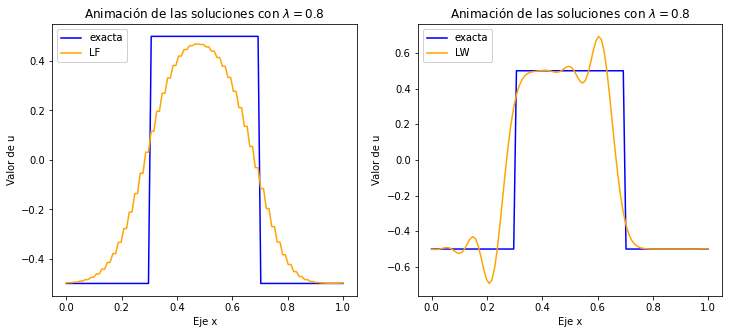

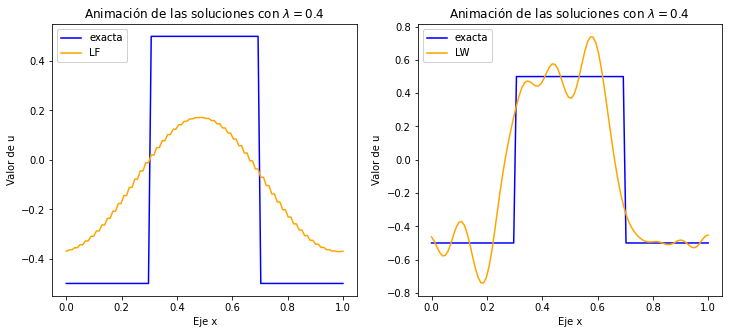

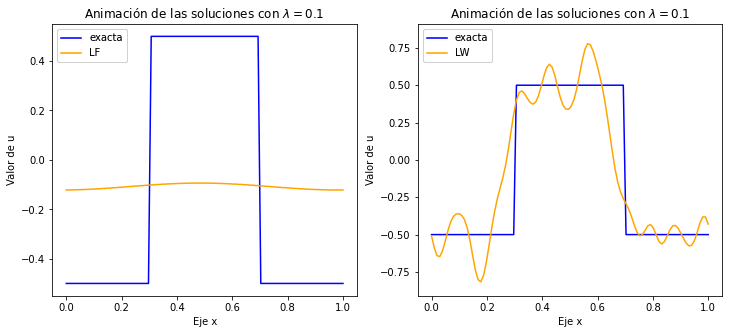

In [79]:
for i in range(len(LAMDA)):
    lamda=LAMDA[i]
    dt=lamda/alpha*dx
    NT=int(T/dt)
    
    #Se calcula los resultados para los metodos LF y Lw para graficarlos
    x,solucion_1=resolver_adveccion(a, b, alpha, dt, NT, N, u0_ext, 'LF')
    solucion_2=resolver_adveccion(a, b, alpha, dt, NT, N, u0_ext, 'LW')[1]
    animar_soluciones(x,solucion_1,solucion_2,i+3,alpha,lamda,u0_ext)

## Comentario

Al igual que en el caso anterior, se observa que el valor de $\lambda$ afecta la "velocidad" en la visualización, pues se tiene que a medida que el lamba es mayor, $\Delta t$ es mayor y eso causa que en la gráfica pareciera que va más rapido que con un $\lambda$ menor, siendo que la velocidad de propagación $\alpha$ es constante.

De esta forma, se observó que la solución numérica correspondiente al esquema de Lax-Wendroff es más estable, pues para $\Delta t$ más pequeños, logra seguir aproximando correctamente la solución original, mientras que la solución del esquema LF tiende a desestabilizarse y convertirse en una recta. 

También se puede apreciar que la condición inicial entregada influye fuertemente en la solución obtenida. Además la aproximación con ambos métodos es menos precisa debido a la discontinuidad de esta nueva función inicial. 

## Ecuación de Burgers aplicado al tráfico vehicular

Uno de los problemas más complicados en la ingeniería de transporte es modelar el funcionamiento de los semáforos. Un modelo continuo para el tráfico vehicular en una única pista, donde no se permite adelantar un automóvil, está dado por la ecuación de Burgers. Asuma que la velocidad máxima está dada por $V$ y la densidad de vehículos por unidad de longitud está dada por $D>0$. Si la velocidad $v$ y la densidad $\rho$ se relacionan mediante la ley
$$
v=V\left(  1-\dfrac{\rho}{D}\right)  \qquad \text{ para }\rho\in\left[
0,D\right]
$$
y se define $u=1-\dfrac{2\rho}{D}$, se puede probar que se cumple la ecuación dada por
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+u\dfrac{\partial u}{\partial x}= &
0 & \qquad \text{para }\left(  t,x\right)  \in\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right)  & \qquad \text{para }x\in\Omega
\end{array}
\right\} \qquad (2)
\end{equation}
$$
donde $-1\leq u\leq1$. El valor $u=-1$ significa que los vehículos no se mueven, pues se llegó a la densidad máxima, mientras que el valor $u=1$ representa que un vehículo que pase por la vía puede ir a la velocidad máxima permitida, puesto que la vía está totalmente vacía.

A diferencia de la primera ecuación analizada en este laboratorio, no es posible obtener una forma explícita para la solución de la ecuación de Burgers, aunque puede probarse que
$$
u\left(  t,x\right)  =u_{0}\left(  x-u\left(  t,x\right)  t\right)
$$
es una expresión implícita para la solución. Además, esta ecuación es no lineal, por lo que aplicar los mismos esquemas antes estudiados requiere un estudio más profundo.

Otra forma de escribir esta ecuación es
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  \dfrac
{1}{2}u^{2}\right]  = & 0 &\qquad \text{ para }\left(  t,x\right)  \in
\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right) &\qquad \text{ para }x\in\Omega
\end{array}
\right\} \qquad (3)
\end{equation}
$$

la cual se conoce como forma conservativa de la ecuación de Burgers. Esta forma es sumamente útil para presentar los esquemas de Lax-Friedrichs y Lax-Wendroff aplicados para esta ecuación. En general, dichos esquemas se presentan para ecuaciones de la forma $\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  f\left(  u\right)  \right] =0$.

Definiendo $\lambda=\dfrac{\Delta t}{\Delta x}$ y $f_{j}^{n}=f(
u_{j}^{n})  $, se presentan los esquemas de Lax-Friedrichs y
Lax-Wendroff en su forma conservativa

$1)$ Lax Friedrichs conservativo:

    1) Paso 1:
$$
F_{j}^{n} = \frac{1}{2}(f_{j-1}^n + f_j^n) - \frac{1}{2\lambda}(u_j^n - u_{j-1}^n)
$$

    2) Paso 2:
$$
u_j^{n+1} = u_j^n - \lambda (F_{j+1}^n - F_j^n)
$$

$2)$ Lax-Wendroff conservativo (esquema de Richtmyer)
Es posible demostrar que estos esquemas son consistentes y convergentes, con
los mismos órdenes que en el caso lineal.

    1) Paso 1:
$$
u_{j+1/2}^n = \frac{1}{2}(u_{j+1}^n + u_j^n) - \frac{\lambda}{2}(f_{j+1}^n - f_j^n)
$$
$$
u_{j-1/2}^n = \frac{1}{2}(u_{j}^n + u_{j-1}^n) - \frac{\lambda}{2}(f_{j}^n - f_{j-1}^n)
$$

    2) Paso 2:
$$
u_{j}^{n+1} =u_{j}^{n}-\lambda\left(  f\left(  u_{j+1/2}^{n}\right)-f\left(  u_{j-1/2}^{n}\right)  \right)
$$

A continuación se simulará el efecto de un flujo de vehículos que entra a una calle a una velocidad mayor a la que tienen otros vehículos que circulan más adelante.

## Ejercicio 2

Sea $f$ una función de clase $\mathcal{C}^{1}$, $T>0$ y $a,b\in\mathbb{R}$, con $a<b$. Considere la ecuación.
$$
\begin{array}{rll}
\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  f\left(
u\right)  \right]   &  =0 & \qquad\text{para }\left(  t,x\right)  \in
(0,T)\times\left(  a,b\right)  \\
u\left(  t,a\right)   &  =u_{a} & \qquad\text{para }t\in\left(  0,T\right]  \\
u\left(  t,b\right)   &  =u_{b} & \qquad\text{para }t\in\left(  0,T\right]  \\
u\left(  0,x\right)   &  =u_{0}(x) & \qquad\text{para }x\in\left[  0,1\right]
\end{array}
$$

**a.** Implemente cada uno de los esquemas de Lax para resolver numéricamente esta ecuación mediante una función. Las entradas de cada programa deben ser la función $f$, $a$, $b$, las condiciones de frontera $u_{a}$ y $u_{b}$, $\Delta t>0$, $N_{T}\in\mathbb{N}$ tal que $N_{T}\Delta t=T$, $N\in\mathbb{N}$ como la cantidad de puntos interiores en su particion del intervalo $\left[  a,b\right]  $ y la condición inicial $u_{0}$ como un vector $\boldsymbol{u}_{0}=\left(  u_{j}^{0}\right)  \in\mathbb{R}^{N+2}$.

In [8]:
def resolver_ej2(f, a, b, ua, ub, dt, NT, N, u0, esquema):
    """Resuelve la ecuacion de adveccion $\partial_t u + \alpha \partial_x u = 0$
    con condiciones periodicas, en el dominio (a,b) y un intervalo de tiempo [0,T].
    -------
    Input:
    - f: function
        funcion en valor de u(t,x) 
    - a: float
        Extremo izquierdo del dominio
    - b: float > a
        Extremo derecho del dominio
    - ua = function
        Funcion que corresponde a la condicion de borde u(t,a)
    - ub = function
        Funcion que corresponde a la condicion de borde u(t,b)
    - dt: float
        paso temporal para el que se resolvera la ecuacion
    - NT: int
        Cumple NT * dt = T
    - N: int
        Cantidad de subintervalos en que se discretizara el dominio. El paso espacial sera (b-a)/(N+1).
    - u0: callable
        Funcion con la condicion inicial del problema
    - esquema: {'LW', 'LF'}
        Esquema usado para resolver la ecuacion.
        - 'LW': Lax Wendroff
        - 'LF': Lax Friedrich
    -------
    Output:
    - x: numpy array, largo N+1
        Discretizacion del dominio donde se calculo la solucion
    - U: numpy array de (N+1)x(NT+1)
        Solucion, evaluada en la grilla en cada paso de tiempo. U[j,n] es la solucion en x_j, 
        en el tiempo t = n*dt.
    -------
    """
    
    #Se calculan los parametros inciales 
    dx=(b-a)/(N+1)
    U=np.zeros((N+2,NT+1))
    F=np.zeros((N+2,NT+1))
    x=np.linspace(a,b,N+2)
    t=np.linspace(dt,dt*NT,NT)
    for j in range(0,N+2):
        U[j,0]=u0(x[j])
    U[0,1:]=ua(t)
    U[-1,1:]=ub(t)
    lamda=dt/dx
    
    #Se implementa el metodo de Lax-Friedrichs conservativo
    if esquema=='LF':
        for n in range(0,NT):
            for j in range(1,N+2):
                F[j,n]=1/2*(f(U[j-1,n])+f(U[j,n]))-1/(2*lamda)*(U[j,n]-U[j-1,n])
            for j in range(1,N+1):
                U[j,n+1]=U[j,n]-lamda*(F[j+1,n]-F[j,n])
    #Se implementa el metodo de Lax-Wendroff conservativo
    else:
        for n in range(0,NT):
            for j in range(1,N+1):
                u_1=1/2*(U[j+1,n]+U[j,n])-lamda/2*(f(U[j+1,n])-f(U[j,n]))
                u_2=1/2*(U[j,n]+U[j-1,n])-lamda/2*(f(U[j,n])-f(U[j-1,n]))
                U[j,n+1]=U[j,n]-lamda*(f(u_1)-f(u_2))
    return x, U


**b.** Considere el dominio $\Omega=\left[  0,1\right]  $, $D=1$, las condiciones de frontera $u\left(  t,0\right)  =0.5$ y $u\left(  t,1\right)  =0$ para todo $t>0$ y la condición inicial dada por
$$
u_{0}\left(  x\right)  =\left\{
\begin{array}
[c]{cc}%
0.5 & \text{si }x<0.2\\
0 & \text{si }x\geq0.2
\end{array}
\right.
$$
Resuelva numéricamente la ecuación de Burgers para este caso usando los esquemas conservativos de Lax-Friedrichs y Lax-Wendroff para $T=2$, $\Delta x\in\left\{  0.01,0.005,0.002\right\}  $ y $\Delta t=0.5\Delta x$. Grafique la velocidad y densidad apropiadamente.

In [9]:
def animar_soluciones_ej2(x,ULF, ULW, dt, NT,i,dx,u0):
    """
    --------
    Input:
    - x: array
        Discretizacion de [0,1]
    - ULF, ULF: array
        Soluciones obtenidas con `resolver_adveccion` con los metodos LF y LW.
    - i: int
        indice auxiliar que sirve para guardar los gif
    - NT: array
        Guarda los tiempos de las soluciones
    - dx: Paso de distancia de la grilla x
    - u0: function
        Condicicion Inicial
    --------
    """

    #Definir parámetros de la figura
    fig, axes = plt.subplots(3, 2, figsize=(15,20))
    
    #Inicializar animacion
    camera = Camera(fig)
    
    #Comenzar a graficar
    for n in range(NT+1):
        
        V=60 #Velocidad Inicial
        rho_LW=(1-ULW[:,n])/2 #Densidad usando LW
        rho_LF=(1-ULF[:,n])/2 #Densidad usando LF
        v_LW=V*(1-rho_LW) #Velocidad usando LW
        v_LF=V*(1-rho_LF) #Velocidad usando LF
        
        # Mismas variables anteriores usando la solucion exacta
        Exacta_LF=np.array(list(map(u0, x-ULF[:,n]*n*dt)))
        Exacta_LW=np.array(list(map(u0, x-ULW[:,n]*n*dt)))
        rho_LW_exacto=(1-Exacta_LW)/2
        rho_LF_exacto=(1-Exacta_LF)/2
        v_LW_exacta=V*(1-rho_LW_exacto)
        v_LF_exacta=V*(1-rho_LF_exacto)
                           
        #Creacion de los labels para la animacion
        labels1 = ['exacta','LF']
        labels2 = ['exacta','LW']
        colors = ['red','blue']
        handles1 = []
        handles2 = []
        for c, l in zip(colors, labels1):
            handles1.append(Line2D([0], [0], color = c, label = l))
        for c, l in zip(colors, labels2):
            handles2.append(Line2D([0], [0], color = c, label = l))

        #Grafico de la solucion con LF
        axes[0,0].legend(handles = handles1, loc = 'upper left')
        axes[0,0].set_title(r'Animación de las soluciones con $\lambda = $'+str(dx))
        axes[0,0].plot(x, Exacta_LF,color='red')
        axes[0,0].plot(x, ULF[:,n],color='blue')
        axes[0,0].set_xlabel('Eje x')
        axes[0,0].set_ylabel('Valor de u')

        #Grafico de la solucion con LW
        axes[0,1].legend(handles = handles2, loc = 'upper left')
        axes[0,1].set_title(r'Animación de las soluciones con $\lambda = $'+str(dx))
        axes[0,1].plot(x,Exacta_LW,color='red')
        axes[0,1].plot(x, ULW[:,n],color='blue')
        axes[0,1].set_xlabel('Eje x')
        axes[0,1].set_ylabel('Valor de u')
        
        #Densidad
        axes[1,0].legend(handles = handles1, loc = 'upper left')
        axes[1,0].set_title('Animación de la densidad')
        axes[1,0].plot(x,rho_LF_exacto,color='red')
        axes[1,0].plot(x, rho_LF,color='blue')
        axes[1,0].set_xlabel('Eje x')
        axes[1,0].set_ylabel('Valor de la densidad')
        
        axes[1,1].legend(handles = handles1, loc = 'upper left')
        axes[1,1].set_title('Animación de la densidad')
        axes[1,1].plot(x,rho_LW_exacto,color='red')
        axes[1,1].plot(x, rho_LW,color='blue')
        axes[1,1].set_xlabel('Eje x')
        axes[1,1].set_ylabel('Valor de la densidad')
        
        #Velocidad
        axes[2,0].legend(handles = handles1, loc = 'upper left')
        axes[2,0].set_title('Animación de la velocidad')
        axes[2,0].plot(x,v_LF_exacta,color='red')
        axes[2,0].plot(x,v_LF,color='blue')
        axes[2,0].set_xlabel('Eje x')
        axes[2,0].set_ylabel('Valor de la velocidad')
        
        axes[2,1].legend(handles = handles1, loc = 'upper left')
        axes[2,1].set_title('Animación de la velocidad')
        axes[2,1].plot(x,v_LW_exacta,color='red')
        axes[2,1].plot(x,v_LW,color='blue')
        axes[2,1].set_xlabel('Eje x')
        axes[2,1].set_ylabel('Valor de la velocidad')

        #Toma foto
        camera.snap()
        
    #Exportar animaciones
    anim = camera.animate(blit=False, interval=100)
    anim.save('discretizacion'+str(i)+'_LF_vs_LW_multiple.gif', writer='Pillow', fps=10)

In [10]:
#Condiciones iniciales
u0=lambda x: 0.5 if x<0.2 else 0
ua=lambda x: 0.5
ub=lambda x: 0
f=lambda x: x**2/2 
T=2
b=1
a=0
Dx=np.array([0.01,0.005,0.002])
#Dx=np.array([0.1,0.05,0.02])
dt=0.5*Dx
NT=T/dt
NT=NT.astype(int)
N=((b-a)/Dx).astype(int)-1


MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


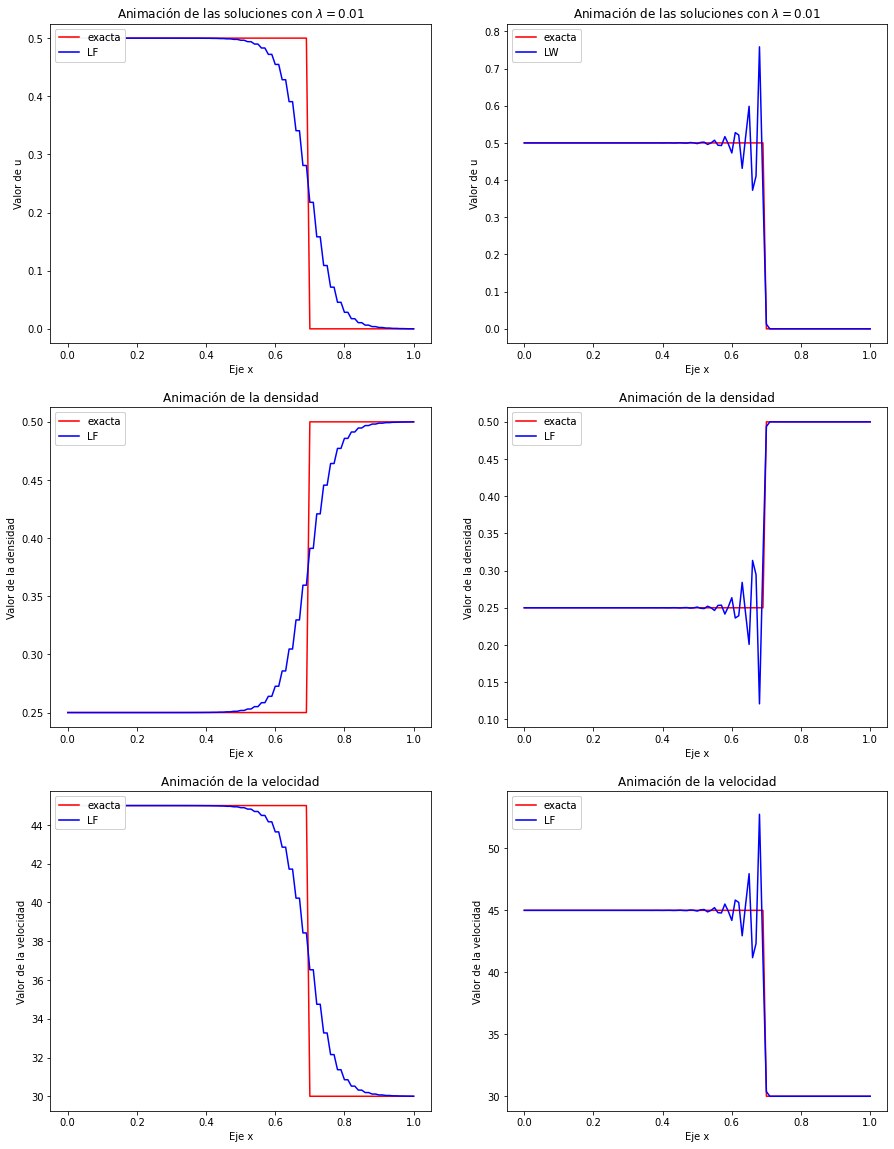

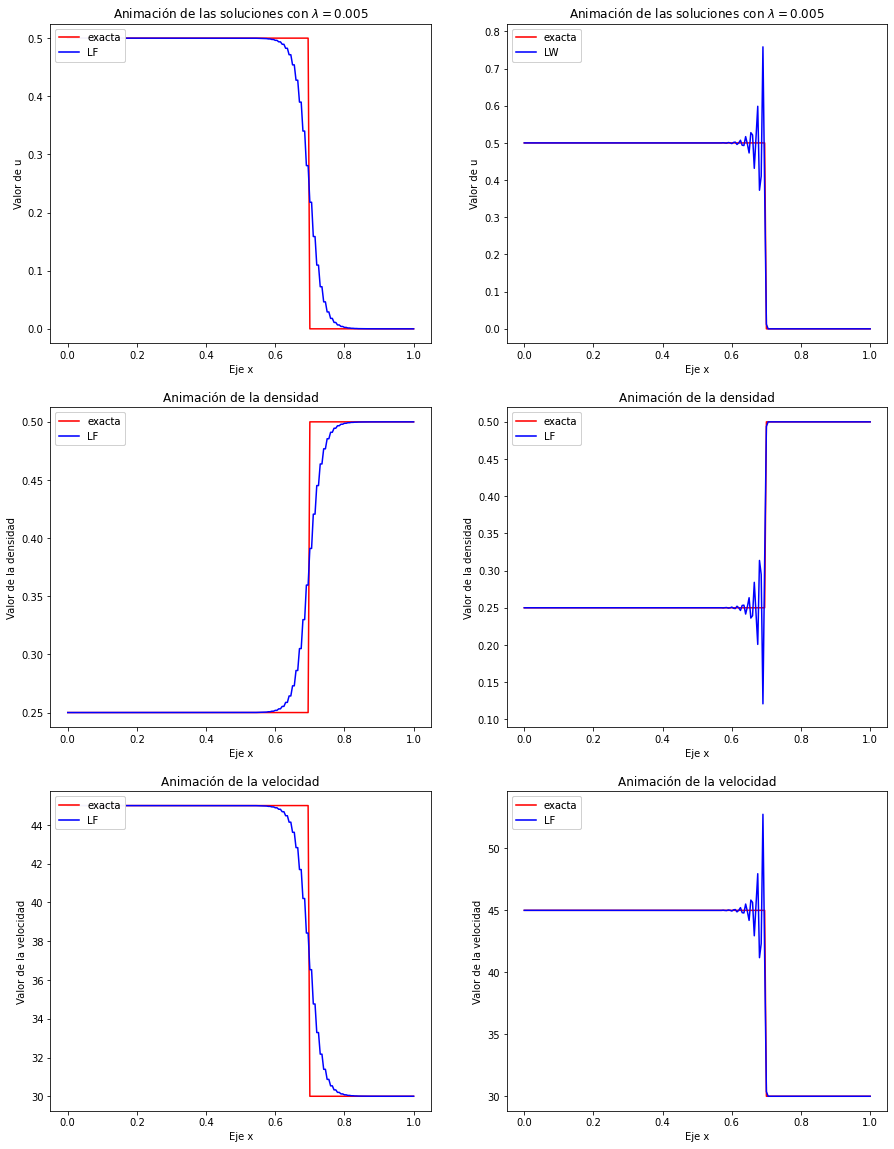

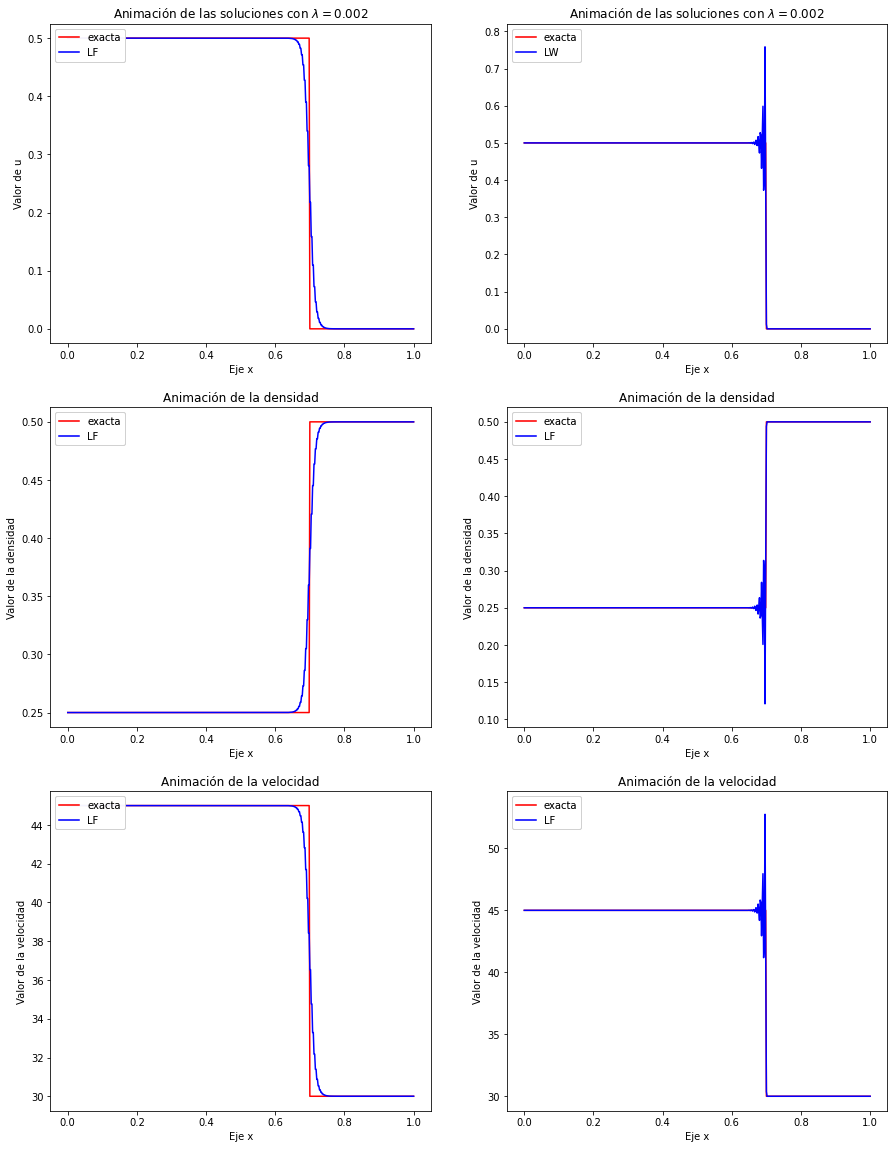

In [13]:
#Se calculan las soluciones y se grafican
soluciones_LF=np.zeros(3,dtype=object)
soluciones_LW=np.zeros(3,dtype=object)
for i in range(3):
    x,soluciones_LF[i]=resolver_ej2(f, a, b, ua, ub, dt[i], NT[i], N[i], u0, 'LF')
    soluciones_LW[i]=resolver_ej2(f, a, b, ua, ub, dt[i], NT[i], N[i], u0, 'LW')[1]
    animar_soluciones_ej2(x,soluciones_LF[i], soluciones_LW[i], dt[i], NT[i], i, Dx[i],u0)

### Comentario

En primer lugar, se puede observar que las soluciones numéricas respetan la condición inicial, pues en el tiempo 0 se puede observar que $u$ tiene un valor de $0$ para los puntos $x$ de la pista que son mayores a $0.2$, y un valor de $0.5$ para los $x$ menores, lo que puede interpretar como que hay autos acumulados circulando desde el $x=0.2$. Luego, se puede observar que a lo largo del tiempo, el valor de $u$ va aumentando para los $x$ mayores a $0.2$.

También se puede observar que los gráficos correspondientes a la densidad y a la velocidad son consistentes con las fórmulas, debido a que la densidad es directamente proporcional al opuesto de la solución, mientras que la velocidad es directamente proporcional a la solución de $u$. Así, se puede observar que la densidad va disminuyendo para los valores de $x$ mayores a $0.2$ a lo largo del tiempo, lo que se puede entender como que el flujo de autos va circulando (y saliendo por $x=1$) y dejando más libre la pista.

Ahora, se modelará el efecto de un semáforo en rojo, el cual cambiará a verde en un par de segundos. Para ello, considere que el tramo de vía a modelar es el intervalo $\left[ 0,2\right] $.

Si existe un semáforo en $x=1$, nuestro dominio de interés para modelar el efecto de la luz roja mediante la ecuación de Burgers será el intervalo $\left[  0,1\right]  $. Suponga que los autos entran por $x=0$ a una velocidad constante, la cual se representará por $u\left(  t,0\right)  =u^{\ast}$. Por otra parte, los vehículos deben detenerse frente al semáforo, por lo que
$u(t,1)=-1$.

Además, se asume que todos los vehículos circulaban a una velocidad inicial constante $u\left(  0,x\right)  =u^{\ast}$ hasta que ven el semáforo en rojo. En el instante $t=T$ en que el semáforo cambia a verde, la densidad de vehículos es nula en $\omega_{2}=\left(  1,2\right]  $. Luego, $u(T,x)=1$, para $x\in\omega_{2}$.

### Ejercicio 3
Simule el efecto del semáforo que cambia de color rojo a verde.


**a.** Resuelva numéricamente la ecuación de Burgers para $t\in\left[0,2\right]  $ en el dominio $\omega_{1}=\left[  0,1\right]  $, considerando la condición inicial
$$
u\left(  0,x\right)  =\left\{
\begin{array}
[c]{cl}%
u^{\ast} & \text{si }0\leq x<1\\
-1 & \text{si }x=1
\end{array}
\right.
$$
y las condiciones de frontera $u\left(  t,0\right)  =u^{\ast}$ y $u(t,1)=-1$, con $u^{\ast}=0.25$. Para ello, use el esquema de Lax-Friedrichs con $\Delta x=0.002$ y $\Delta t=0.1\Delta x$, simulando un semáforo en rojo que dure $T=2$.

In [80]:
b=1
a=0
dx=0.02
dt=0.1*dx
T=2
NT=int(T/dt)
N=int((b-a)/dx-1)

#Se define la funcion correspondiente a la condicion inicial
def u0_1(x):
    if 0<=x<1:
        return 0.25
    elif x==1:
        return -1
    
#u0_1_ext = extension_periodica(0, 1)(u0_1)

#Nuevas condiciones iniciales
ua_1 = lambda x: 0.25
ub_1 = lambda x: -1
x_R,u_R=resolver_ej2(f, a, b, ua_1, ub_1, dt, NT, N, u0_1, 'LF') #se calcula la solucion

In [81]:
#Funcion para graficar la solucion de la ecuacion de Burges usando el metodo LF
def animar_soluciones_ej3(x,ULF, dt, NT,dx,u0,i):
    #Definir parámetros de la figura
    fig, axes = plt.subplots(3, 1, figsize=(15,15))
    
    #Inicializar animacion
    camera = Camera(fig)
    
    #Comenzar a graficar
    for n in range(NT+1):     
        V=60 #Velocidad Inicial
        rho_LF=(1-ULF[:,n])/2
        v_LF=V*(1-rho_LF)                  

        #Grafico Izquierdo
        axes[0].set_title(r'Animación de las soluciones con $\Delta x = $'+str(dx))
        axes[0].plot(x, ULF[:,n],color='blue')
        axes[0].set_ylabel('Valor de u')
        
        #Densidad
        axes[1].set_title('Animación de la densidad')
        axes[1].plot(x, rho_LF,color='orange')
        axes[1].set_ylabel('Valor de la densidad')
        
        #Velocidad
        axes[2].set_title('Animación de la velocidad')
        axes[2].plot(x,v_LF,color='purple')
        axes[2].set_xlabel('Eje x')
        axes[2].set_ylabel('Valor de la velocidad')

        #Toma foto
        camera.snap()
        
    #Exportar animaciones
    anim = camera.animate(blit=False, interval=100)
    anim.save('semaforo'+str(i)+'_LF.gif', writer='Pillow', fps=10)

MovieWriter Pillow unavailable; using Pillow instead.


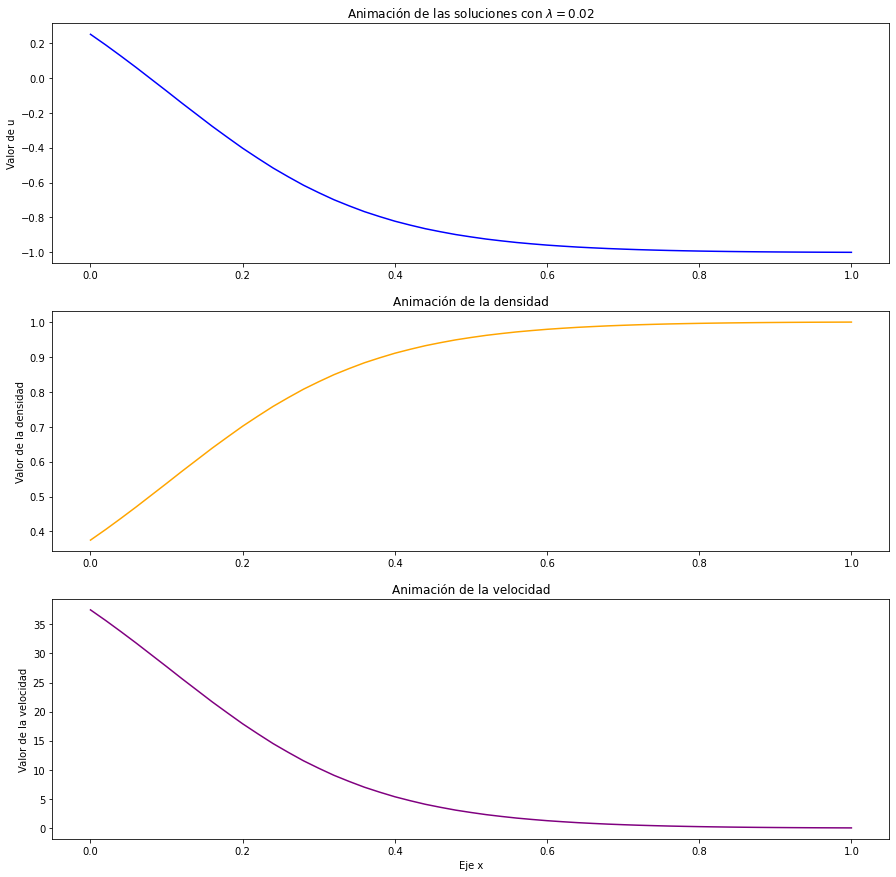

In [13]:
#Se anima la solucion
animar_soluciones_ej3(x_R,u_R, dt, NT,dx,u0_1,1)


**b.** Resuelva numéricamente la ecuación de Burgers para $t\in\left[2,4\right]  $ y $\Omega=\omega_{1}\cup\omega_{2}=\left[  0,2\right]  $, considerando las condiciones de frontera $u\left(  t,0\right)  =u^{\ast}$ y $u(t,2)=1$, y la condición inicial dada por
$$
u\left(  2,x\right)  =\left\{
\begin{array}
[c]{cl}%
u_{R}\left(  2,x\right)   & \text{si }0\leq x\leq1\\
1 & \text{si }x>1
\end{array}
\right.
$$
donde $u_{R}\left(  2,x\right)  $ es la solución numérica resultante en el ejercicio anterior. Use los mismos parámetros y esquema que la parte anterior y grafique su solución solo en el conjunto $\omega_1$.

In [82]:
#Nueva condicion inicial
def u_0_2(x):
    global x_R,u_R
    x_R_list=list(x_R)
    if x in x_R_list:
        i=x_R_list.index(x)
        return u_R[i,-1]
    elif x>1:
        return 1

In [83]:
a_2=0
b_2=2
ua_2 = lambda x: 0.25
ub_2 = lambda x: 1
x_R2,u_R2=resolver_ej2(f, a_2, b_2, ua_2, ub_2, dt, NT, N, u_0_2, 'LF') #Se calcula la solucion

MovieWriter Pillow unavailable; using Pillow instead.


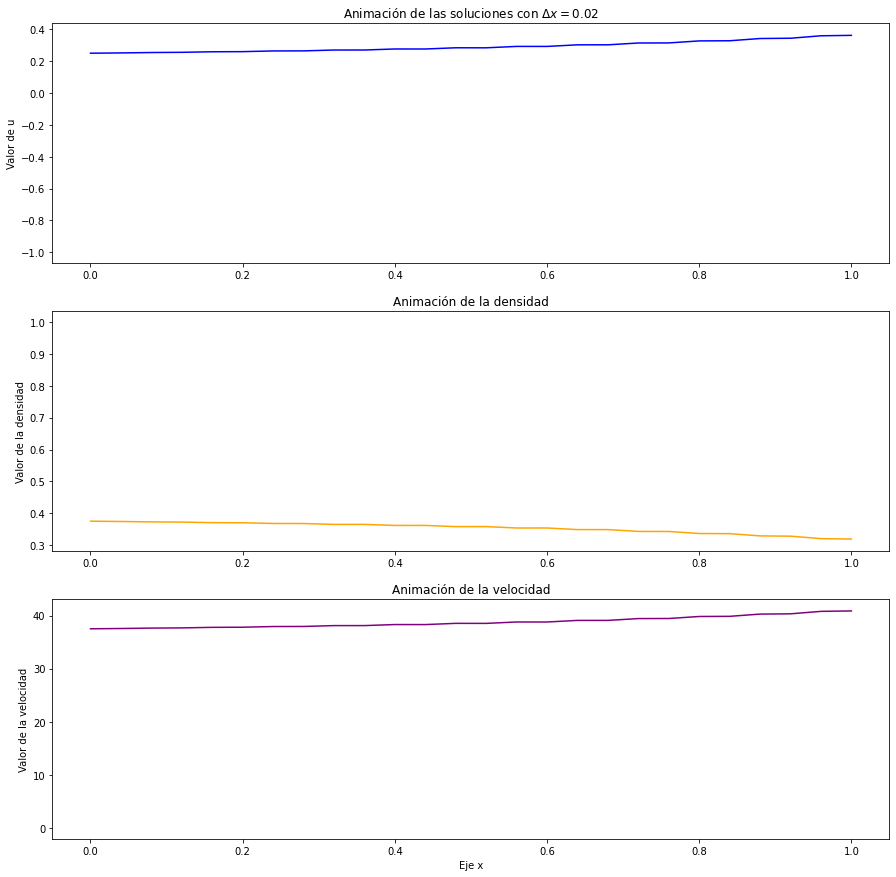

In [84]:
#Se anima la solucion encontrada
u_visualizar=u_R2[0:len(x_R2)//2+1,:]
x_visualizar=x_R2[0:len(x_R2)//2+1]
animar_soluciones_ej3(x_visualizar,u_visualizar, dt, NT,dx,u_0_2,2)

**c.** Interprete los resultados

Los gráficos fueron realizos con $\Delta x=0.02$ (un orden menor al pedido), debido a que nuestro computadores no fueron capaces de ejecutar el código con dicho valor. 

En el gráfico de la parte $a$, se puede observar que inicialmente la densidad de vehículos es pequeña en toda la pista, mientras que la velocidad a la que se puede viajar y el valor de $u$ es grande. En este momento, el semáfoto ubicado en $x=1$ cambia a rojo, lo que genera que se genere una acumulación de gráfico (mayor densidad, menor velocidad, menor $u$) que se propaga por toda la pista desde las cercanías del semáforo (desde $x=1$ hacia $x=0$).

Por otro lado, en el gráfico de la parte $b$, el cual inicia con las condiciones finales del de la parte $a$ ya mencionadas, se puede observar que el semáforo cambia a verde, y con ello, se va descongestionando la pista a lo largo del tiempo, lo que se traduce en que la densidad va achicándose para todos los $x$ de la pista, mientras que la velocidad permitida y el valor de $u$ van creciendo.